In [1]:
import torch, torchvision
# Code was not working with v2, so refactored it
# Define transforms without using v2 prefix
training_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomResizedCrop(size=32, scale=[0.85, 1.0], interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
])

# Define the CIFAR-10 datasets with the transforms
training_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=True,
    download=False,
    transform=training_transform
)

test_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=False,
    download=False,
    transform=torchvision.transforms.ToTensor()
)

# Split training data into training and validation
training_data, validation_data = torch.utils.data.random_split(training_data, [40000, 10000], generator=torch.Generator().manual_seed(55))

batch_size = 256 #original 128

# Create dataloaders
train_dataloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    num_workers=4
)

val_dataloader = torch.utils.data.DataLoader(
    validation_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False,
    num_workers=4
)

'''from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=True,
    download=False,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=False,
    download=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=4)
val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=4)'''

'from torchvision.transforms import v2\ntraining_data = torchvision.datasets.CIFAR10(\n    root="/lus/eagle/projects/datasets/CIFAR-10/",\n    train=True,\n    download=False,\n    transform=v2.Compose([\n        v2.ToTensor(),\n        v2.RandomHorizontalFlip(),\n        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),\n        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),\n    ])\n)\n\ntest_data = torchvision.datasets.CIFAR10(\n    root="/lus/eagle/projects/datasets/CIFAR-10/",\n    train=False,\n    download=False,\n    transform=torchvision.transforms.ToTensor()\n)\n\ntraining_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))\n\nbatch_size = 128\n\n# The dataloader makes our dataset iterable \ntrain_dataloader = torch.utils.data.DataLoader(training_data, \n    batch_size=batch_size, \n    pin_memory=True,\n    shuffle=True, \n    num_workers=4)\nval_dataloader = torch.utils.

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

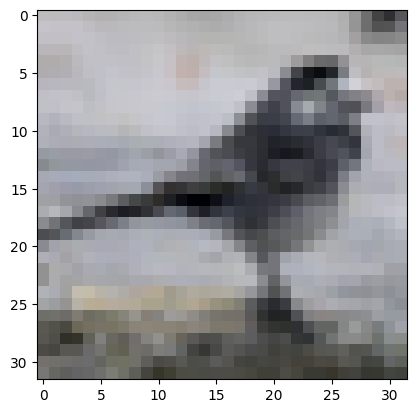

In [3]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1,2,0))); plt.show()

In [4]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [7]:
from torch import nn

class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):

        return self.downsample(self.norm(inputs))
        

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """

    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, separable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=7,  # Changed number of filters to 7
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=7,  # Changed number of filters to 7
                                     out_channels=4*7,  # Changed number of filters to 4*7
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*7,  # Changed number of filters to 4*7
                                     out_channels=7,  # Changed number of filters to 7
                                     kernel_size=1
                                     )

    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [8]:
model = Classifier(64, 4, 2)

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [256, 10]                 --
├─Conv2d: 1-1                            [256, 64, 32, 32]         256
├─LayerNorm: 1-2                         [256, 64, 32, 32]         131,072
├─Sequential: 1-3                        [256, 512, 4, 4]          --
│    └─ConvNextBlock: 2-1                [256, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [256, 64, 32, 32]         3,200
│    │    └─LayerNorm: 3-2               [256, 64, 32, 32]         131,072
│    │    └─Conv2d: 3-3                  [256, 256, 32, 32]        16,640
│    │    └─Conv2d: 3-4                  [256, 64, 32, 32]         16,448
│    └─ConvNextBlock: 2-2                [256, 64, 32, 32]         --
│    │    └─Conv2d: 3-5                  [256, 64, 32, 32]         3,200
│    │    └─LayerNorm: 3-6               [256, 64, 32, 32]         131,072
│    │    └─Conv2d: 3-7                  [256, 256, 32,

In [9]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()
            
    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss


In [10]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()      

        progress_bar.update()

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [12]:
from tqdm.notebook import tqdm


epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)
    
    # checking on the training loss and accuracy once per epoch
        
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)

        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
    

Train Epoch 0:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0: training loss: 1.995, accuracy: 26.334


Validate Epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.979, accuracy: 26.260


Train Epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1: training loss: 1.598, accuracy: 42.513


Validate Epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.598, accuracy: 41.973


Train Epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2: training loss: 1.365, accuracy: 50.552


Validate Epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.380, accuracy: 49.160


Train Epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3: training loss: 1.274, accuracy: 54.250


Validate Epoch 3:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.308, accuracy: 52.314


Train Epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4: training loss: 1.149, accuracy: 58.974


Validate Epoch 4:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.207, accuracy: 56.279


Train Epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5: training loss: 0.985, accuracy: 65.222


Validate Epoch 5:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.078, accuracy: 60.137


Train Epoch 6:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6: training loss: 0.903, accuracy: 68.160


Validate Epoch 6:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.011, accuracy: 63.643


Train Epoch 7:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7: training loss: 0.770, accuracy: 72.524


Validate Epoch 7:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.944, accuracy: 65.605


Train Epoch 8:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8: training loss: 0.725, accuracy: 74.147


Validate Epoch 8:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.938, accuracy: 66.318


Train Epoch 9:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9: training loss: 0.583, accuracy: 79.685


Validate Epoch 9:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.841, accuracy: 69.971


Train Epoch 10:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10: training loss: 0.514, accuracy: 82.198


Validate Epoch 10:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.810, accuracy: 70.693


Train Epoch 11:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11: training loss: 0.411, accuracy: 85.432


Validate Epoch 11:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.758, accuracy: 72.646


Train Epoch 12:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12: training loss: 0.376, accuracy: 86.754


Validate Epoch 12:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.768, accuracy: 73.164


Train Epoch 13:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13: training loss: 0.362, accuracy: 87.159


Validate Epoch 13:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.811, accuracy: 72.666


Train Epoch 14:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14: training loss: 0.245, accuracy: 91.401


Validate Epoch 14:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.771, accuracy: 74.385


Train Epoch 15:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15: training loss: 0.223, accuracy: 92.028


Validate Epoch 15:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.794, accuracy: 74.600


Train Epoch 16:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16: training loss: 0.209, accuracy: 92.454


Validate Epoch 16:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.817, accuracy: 74.482


Train Epoch 17:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17: training loss: 0.196, accuracy: 92.926


Validate Epoch 17:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.891, accuracy: 74.570


Train Epoch 18:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18: training loss: 0.189, accuracy: 93.118


Validate Epoch 18:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.907, accuracy: 73.857


Train Epoch 19:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19: training loss: 0.139, accuracy: 94.895


Validate Epoch 19:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.858, accuracy: 74.639


Train Epoch 20:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20: training loss: 0.138, accuracy: 94.890


Validate Epoch 20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.891, accuracy: 74.941


Train Epoch 21:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 21: training loss: 0.128, accuracy: 95.263


Validate Epoch 21:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.862, accuracy: 75.908


Train Epoch 22:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 22: training loss: 0.116, accuracy: 95.673


Validate Epoch 22:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.890, accuracy: 75.156


Train Epoch 23:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 23: training loss: 0.105, accuracy: 95.967


Validate Epoch 23:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.902, accuracy: 75.986


Train Epoch 24:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 24: training loss: 0.095, accuracy: 96.348


Validate Epoch 24:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.869, accuracy: 75.625


Train Epoch 25:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 25: training loss: 0.097, accuracy: 96.295


Validate Epoch 25:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.895, accuracy: 76.406


Train Epoch 26:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 26: training loss: 0.095, accuracy: 96.372


Validate Epoch 26:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.970, accuracy: 75.605


Train Epoch 27:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 27: training loss: 0.095, accuracy: 96.253


Validate Epoch 27:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.922, accuracy: 76.250


Train Epoch 28:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 28: training loss: 0.078, accuracy: 96.858


Validate Epoch 28:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.873, accuracy: 76.611


Train Epoch 29:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 29: training loss: 0.082, accuracy: 96.723


Validate Epoch 29:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.961, accuracy: 76.475
